# Imports

In [1]:
import pandas as pd
import numpy as np
import operator
import ast
import matplotlib.pyplot as plt

# Read Data
All regular season regulation fourth downs 2009-2017. 

In [2]:
data = pd.read_csv("fourth_down_EWPA.csv")

Removing fake punts and field goals.

In [3]:
punt_fg_formations = data[data["desc"].str.contains("Punt formation|Field Goal formation")]
fakes = punt_fg_formations[((punt_fg_formations["Passer_ID"] != "None") | (punt_fg_formations["Rusher_ID"] != "None")) & ~(punt_fg_formations["desc"].str.contains("Aborted"))]
data = pd.concat([data, fakes, fakes]).drop_duplicates(keep=False)

Removing 4th quarter due to significance of game situation and decrease in performance of WP in late game situations

In [4]:
# data = data[data["qtr"] != 4]

# Has Playcalling Improved Over Time?
Graphing percent of correct fourth down calls and average EWPA of fourth down calls by year 2009-2017.

In [5]:
seasons = {}
for index, row in data.iterrows():
    season = row["Season"]
    if season in seasons:
        seasons[season].append(float(row["call_vs_best_EWPA"]))
    else:
        seasons[season] = [float(row["call_vs_best_EWPA"])]

seasons_vs_best = {"year": [], "avg_vs_best": [], "percent_of_perfect_calls": []}
for key, value in seasons.items():
    seasons_vs_best["year"].append(key)
    seasons_vs_best["avg_vs_best"].append(sum(value) / len(value))
    seasons_vs_best["percent_of_perfect_calls"].append(float(value.count(0.0)) / len(value))

seasons_vs_best_df = pd.DataFrame(seasons_vs_best)
columns = ["year", "percent_of_perfect_calls", "avg_vs_best"]
seasons_vs_best_df = seasons_vs_best_df[columns]

seasons_vs_best_df.to_csv("playcalling_by_year.csv", encoding="utf-8", index=False)

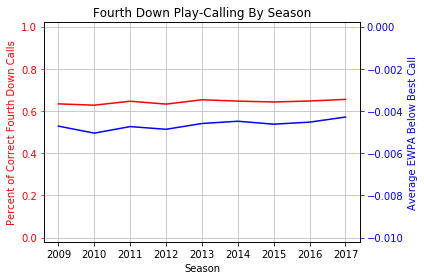

In [6]:
fig, ax1 = plt.subplots()
x1 = seasons_vs_best_df.year
y1 = seasons_vs_best_df.percent_of_perfect_calls
ax1.plot(x1, y1, "r-")
ax1.set_title("Fourth Down Play-Calling By Season")
ax1.set_xlabel("Season")
ax1.set_ylabel("Percent of Correct Fourth Down Calls", color="r")
ax1.tick_params("y", colors="r")
ax1.set_ylim(-0.02, 1.02)
ax1.grid(True, linestyle="-", color="0.75")

ax2 = ax1.twinx()
y2 = seasons_vs_best_df.avg_vs_best
ax2.plot(x1, y2, "b-")
ax2.set_ylabel("Average EWPA Below Best Call", color="b")
ax2.tick_params("y", colors="b")
ax2.set_ylim(-0.0102, 0.0002)

fig.tight_layout()
plt.show()

# What Are Coaches Calling When They Make The Wrong Call?

In [7]:
def num_plays_below_EWPA(data, EWPA_bound):
    data = data[data["call_vs_best_EWPA"] < EWPA_bound]   
    num_plays = len(data.index)
    bad_fg_count = 0
    bad_punt_count = 0
    bad_go_for_count = 0
    best_fg_count = 0
    best_punt_count = 0
    best_go_for_count = 0
    for index, row in data.iterrows():
        if row["fourth_down_play_type"] == 0:
            bad_fg_count += 1
        elif row["fourth_down_play_type"] == 1:
            bad_punt_count += 1
        else:
            bad_go_for_count += 1
            
        EWPAs = [float(i) for i in ast.literal_eval(row["EWPA_of_each_call"])]
        if EWPAs[0] == max(EWPAs):
            best_fg_count += 1
        elif EWPAs[1] == max(EWPAs):
            best_punt_count += 1
        elif EWPAs[2] == max(EWPAs):
            best_go_for_count += 1
            
    return [num_plays, bad_fg_count, bad_punt_count, bad_go_for_count, best_fg_count, best_punt_count, best_go_for_count]

In [8]:
cols = ["EWPA", "num_plays", "fg", "punt", "go_for_it"]
bad_calls = pd.DataFrame(columns=cols)
best_calls = pd.DataFrame(columns=cols)
for i in [0, -0.025, -0.05]:
    num_plays, bad_fg_count, bad_punt_count, bad_go_for_count, best_fg_count, best_punt_count, best_go_for_count = num_plays_below_EWPA(data, i)
    bad_calls.loc[i] = [i, num_plays, bad_fg_count, bad_punt_count, bad_go_for_count]
    best_calls.loc[i] = [i, num_plays, best_fg_count, best_punt_count, best_go_for_count]
    
bad_calls = bad_calls.reset_index(drop=True)
best_calls = best_calls.reset_index(drop=True)

EWPA column represents exclusive upper bound of EWPA versus best available call (i.e. every play in EWPA 0 row was not the best available call, every play in -0.025 row was at least 2.5% WP worst than best call, etc.). num_plays is the number of plays meeting this EWPA condition, fg is how many of those times they wrongfully chose to kick a field goal, punt is number of bad punt calls, and go_for_it number of bad calls to attempt a conversion.

In [9]:
bad_calls

,EWPA,num_plays,fg,punt,go_for_it
0,0,12751,3608,7110,2033
1,-0.025,2007,736,771,500
2,-0.05,329,158,20,151


Same as above table except now showing what coaches should have called, i.e. fg now represents how many of the times when a coach made a bad call the best call would have been to instead attempt a field goal.

In [10]:
best_calls

,EWPA,num_plays,fg,punt,go_for_it
0,0,12751,1734,1177,9840
1,-0.025,2007,262,380,1365
2,-0.05,329,29,125,175


### Graphing Findings

In [11]:
# https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py
def autolabel(rects):
    for rect in rects:
        rect = rect[0]
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

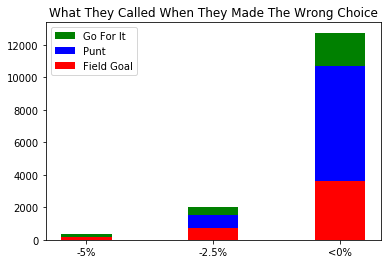

In [12]:
fig, ax = plt.subplots()
colors = ["red", "blue", "green"]
# https://stackoverflow.com/questions/47205918/plot-multiple-stacked-bar-in-the-same-figure
bad_call_bars = [ax.bar(bad_calls["EWPA"], bad_calls["fg"] + bad_calls["punt"] + bad_calls["go_for_it"], width=0.01, color=colors[2]),
                ax.bar(bad_calls["EWPA"], bad_calls["fg"] + bad_calls["punt"], width=0.01, color=colors[1]),
                ax.bar(bad_calls["EWPA"], bad_calls["fg"], width=0.01, color=colors[0])]
# autolabel(bad_call_bars)

ax.set_xticks([-0.05, -0.025, 0])
ax.set_xticklabels(["-5%", "-2.5%", "<0%"])
ax.set_title("What They Called When They Made The Wrong Choice")
ax.legend(tuple(["Go For It", "Punt", "Field Goal"]))
plt.show()

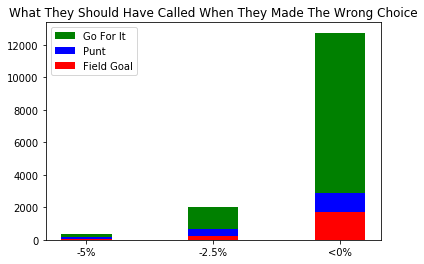

In [13]:
fig, ax = plt.subplots()
colors = ["red", "blue", "green"]
best_call_bars = [ax.bar(best_calls["EWPA"], best_calls["fg"] + best_calls["punt"] + best_calls["go_for_it"], width=0.01, color=colors[2]),
                ax.bar(best_calls["EWPA"], best_calls["fg"] + best_calls["punt"], width=0.01, color=colors[1]),
                ax.bar(best_calls["EWPA"], best_calls["fg"], width=0.01, color=colors[0])]

ax.set_xticks([-0.05, -0.025, 0])
ax.set_xticklabels(["-5%", "-2.5%", "<0%"])
ax.set_title("What They Should Have Called When They Made The Wrong Choice")
ax.legend(tuple(["Go For It", "Punt", "Field Goal"]))
plt.show()

# Split By Team-Season
Getting stats and rates by team-season.

In [14]:
data["offense_team_season"] = data.apply(lambda row: (row["posteam"] + "_" + str(row["Season"])), axis=1)
data["defense_team_season"] = data.apply(lambda row: (row["DefensiveTeam"] + "_" + str(row["Season"])), axis=1)
data["punt_return_td"] = np.where(data["ReturnResult"] == "Touchdown", 1, 0)
data["fg_made_vs_expected"] = np.where((data["fourth_down_play_type"] == 0) & (data["FieldGoalResult"] == "Good"), 1 - data["prob_make_fg"], np.where(data["fourth_down_play_type"] == 0, -data["prob_make_fg"], 0))
data["conversion_attempted"] = np.where(data["fourth_down_play_type"] == 2, 1, 0)
data["conversion_successful"] = np.where((data["fourth_down_play_type"] == 2) & (data["Yards.Gained"] >= data["ydstogo"]), 1, 0)
data["conversion_expected"] = np.where((data["fourth_down_play_type"] == 2), (data["prob_convert_no_td"] + data["prob_td"]), 0)

In [15]:
offensive_team_data = data.groupby("offense_team_season").sum()
offensive_team_data = offensive_team_data.reset_index()
offensive_team_data = offensive_team_data[["offense_team_season", "PlayAttempted", "call_vs_best_EWPA", "WPA_execution_given_call", "punt_return_td", "fg_made_vs_expected", "conversion_attempted", "conversion_successful", "conversion_expected"]]
offensive_team_data = offensive_team_data.rename(columns={"offense_team_season": "team_season", "PlayAttempted": "number_fourth_downs", "call_vs_best_EWPA": "cumulative_EWPA_vs_best", "WPA_execution_given_call": "cumulative_offensive_performance", "punt_return_td": "punt_return__tds_for", "fg_made_vs_expected": "fgs_vs_expected_for", "conversion_attempted": "conversions_attempted_for", "conversion_successful": "successful_conversions_for", "conversion_expected": "conversions_expected_for"})

defensive_team_data = data.groupby("defense_team_season").sum()
defensive_team_data = defensive_team_data.reset_index()
defensive_team_data = defensive_team_data[["defense_team_season", "PlayAttempted", "call_vs_best_EWPA", "WPA_execution_given_call", "punt_return_td", "fg_made_vs_expected", "conversion_attempted", "conversion_successful", "conversion_expected"]]
defensive_team_data = defensive_team_data.rename(columns={"defense_team_season": "team_season", "PlayAttempted": "number_fourth_downs_against", "call_vs_best_EWPA": "cumulative_EWPA_vs_best_against", "WPA_execution_given_call": "cumulative_defensive_performance", "punt_return_td": "punt_return__tds_against", "fg_made_vs_expected": "fgs_vs_expected_against", "conversion_attempted": "conversions_attempted_against", "conversion_successful": "successful_conversions_against", "conversion_expected": "conversions_expected_against"})

team_data = offensive_team_data.merge(defensive_team_data, left_on="team_season", right_on="team_season")

team_data["average_EWPA_vs_best"] = team_data.apply(lambda row: row["cumulative_EWPA_vs_best"] / row["number_fourth_downs"], axis=1)
team_data["average_EWPA_vs_best_against"] = team_data.apply(lambda row: row["cumulative_EWPA_vs_best_against"] / row["number_fourth_downs_against"], axis=1)
team_data["average_offensive_performance"] = team_data.apply(lambda row: row["cumulative_offensive_performance"] / row["number_fourth_downs"], axis=1)
team_data["average_defensive_performance"] = team_data.apply(lambda row: row["cumulative_defensive_performance"] / row["number_fourth_downs"], axis=1)
team_data["conversion_rate_for"] = team_data.apply(lambda row: row["successful_conversions_for"] / row["conversions_attempted_for"], axis=1)
team_data["expected_conversion_rate_for"] = team_data.apply(lambda row: row["conversions_expected_for"] / row["conversions_attempted_for"], axis=1)
team_data["conversion_rate_against"] = team_data.apply(lambda row: row["successful_conversions_against"] / row["conversions_attempted_against"], axis=1)
team_data["expected_conversion_rate_against"] = team_data.apply(lambda row: row["conversions_expected_against"] / row["conversions_attempted_against"], axis=1)

In [16]:
team_data.to_csv('fourth_down_team_stats.csv', encoding='utf-8', index=False)

# How Have Individual Coaches Performed?
coach_info.csv gathered manually from https://www.pro-football-reference.com/. Coaches only recorded if they coached entire season, otherwise coach is "none".

In [17]:
coach_info = pd.read_csv("coach_info.csv")
coach_info["seasons_coached"] = 1
team_data_with_coaches = team_data.merge(coach_info, left_on="team_season", right_on="team_season")

In [18]:
team_data_with_coaches = team_data_with_coaches.groupby("coach").sum()
team_data_with_coaches = team_data_with_coaches.reset_index()

# only keep columns relevant to fourth down decision (as in FG vs. punt vs. conversion attempt, not trying to imply that a good trick play call is irrelevant to coaching, it's just not what we're examining here)
team_data_with_coaches["win_percentage"] = team_data_with_coaches.apply(lambda row: (row["wins"] + .05 * row["ties"]) / (16 * row["seasons_coached"]), axis=1)
team_data_with_coaches = team_data_with_coaches[["coach", "seasons_coached", "wins", "ties", "win_percentage", "number_fourth_downs", "cumulative_EWPA_vs_best", "average_EWPA_vs_best", "conversions_attempted_for", "successful_conversions_for", "conversions_expected_for", "conversion_rate_for", "expected_conversion_rate_for"]]

# recalculate relevant average and rate columns (when we performed groupby we also summed every column but summing averages obviously does not get the new average)
team_data_with_coaches["average_EWPA_vs_best"] = team_data_with_coaches.apply(lambda row: row["cumulative_EWPA_vs_best"] / row["number_fourth_downs"], axis=1)
team_data_with_coaches["conversion_rate_for"] = team_data_with_coaches.apply(lambda row: row["successful_conversions_for"] / row["conversions_attempted_for"], axis=1)
team_data_with_coaches["expected_conversion_rate_for"] = team_data_with_coaches.apply(lambda row: row["conversions_expected_for"] / row["conversions_attempted_for"], axis=1)

In [19]:
team_data_with_coaches

,coach,seasons_coached,wins,ties,win_percentage,number_fourth_downs,cumulative_EWPA_vs_best,average_EWPA_vs_best,conversions_attempted_for,successful_conversions_for,conversions_expected_for,conversion_rate_for,expected_conversion_rate_for
0,Adam Gase,2,16,0,0.500000,247,-1.000440,-0.004050,35,8,16.35,0.228571,0.467143
1,Andy Reid,9,86,0,0.597222,1104,-4.822144,-0.004368,159,64,85.83,0.402516,0.539811
2,Anthony Lynn,1,9,0,0.562500,121,-0.570729,-0.004717,21,5,12.01,0.238095,0.571905
3,Ben McAdoo,1,11,0,0.687500,137,-0.742329,-0.005418,23,9,12.84,0.391304,0.558261
4,Bill Belichick,9,112,0,0.777778,1042,-4.222739,-0.004053,184,79,102.47,0.429348,0.556902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Tom Coughlin,7,55,0,0.491071,835,-4.084901,-0.004892,126,45,67.37,0.357143,0.534683
67,Tony Sparano,2,14,0,0.437500,253,-1.513124,-0.005981,40,20,21.98,0.500000,0.549500
68,Vance Joseph,1,5,0,0.312500,138,-0.585515,-0.004243,31,8,13.81,0.258065,0.445484
69,Wade Phillips,1,11,0,0.687500,114,-0.562679,-0.004936,15,4,8.72,0.266667,0.581333


In [20]:
team_data_with_coaches.to_csv('fourth_down_coach_stats.csv', index=False)

# Michael Lopez's Tweet
Comparing my model originally from early-mid 2018 (only slightly revised to date) to this December, 2019 Tweet from @StatsbyLopez https://twitter.com/StatsbyLopez/status/1211759915724873729 regarding how NFL fourth down play-calling  changed in 2019 versus previous years.

In [21]:
chances = {'01':[0]*99, '02':[0]*99, '03':[0]*99, '04-06':[0]*99, '07-10':[0]*99}
went_for = {'01':[0]*99, '02':[0]*99, '03':[0]*99, '04-06':[0]*99, '07-10':[0]*99}
should_have = {'01':[0]*99, '02':[0]*99, '03':[0]*99, '04-06':[0]*99, '07-10':[0]*99}

data["to_first_bin"] = np.where(data["ydstogo"] == 1, "01", np.where(data["ydstogo"] == 2, "02", np.where(data["ydstogo"] == 3, "03", np.where(data["ydstogo"] <= 6, "04-06", np.where(data["ydstogo"] <= 10, "07-10", "11+")))))
for index, row in data.iterrows():
    if row["ydstogo"] <= 10:
        yard_line = 99 - int(row["yrdline100"]) # from own endzone minus one
        calls = ast.literal_eval(row["EWPA_of_each_call"])
        calls_sorted = sorted(calls)
        chances[row["to_first_bin"]][yard_line] += 1
        if row["fourth_down_play_type"] == 2:
            went_for[row["to_first_bin"]][yard_line] += 1
            if calls.index(max(calls)) == 2:
                should_have[row["to_first_bin"]][yard_line] += 1
        elif calls.index(max(calls)) == 2 and (calls_sorted[2] > calls_sorted[1] + 0.01): # if they didn't go for it, must have been at least 1% WP better to have gone for it than not to say they should have gone for it -- basically saying if it was a significantly incorrect call
            should_have[row["to_first_bin"]][yard_line] += 1

In [22]:
def smooth(l, width): # l is tuple (value, num observations). If width even treated as width - 1
    smooth = [i[0] for i in l]
    for i in range(len(l)):
        val = 0
        obs = 0
        for j in range(i-int((width-1)/2),i+int((width-1)/2)+1):
            if j in range(len(l)):
                val += l[j][0] * l[j][1]
                obs += l[j][1]
        if obs > 0:
            smooth[i] = val / obs
    return smooth

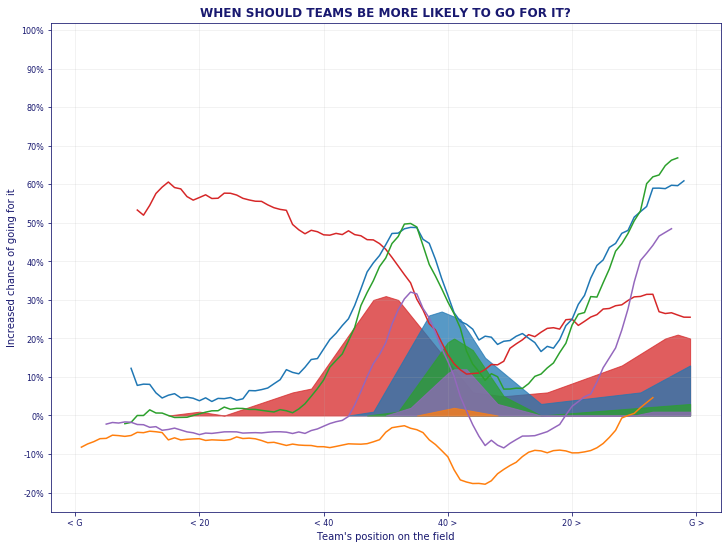

In [23]:
fig, ax = plt.subplots()

for key, value in went_for.items():
    x = [i+1 for i in range(99)]
    y = [0]*99
    for i in range(len(went_for[key])):
        if chances[key][i] > 0:
            y[i] = ((should_have[key][i] - went_for[key][i]) / chances[key][i], chances[key][i])
        else:
            y[i] = (0, 0)

    color = 'tab:orange'
    if key == '01':
        color = 'tab:red'
    elif key == '02':
        color = 'tab:blue'
    elif key == '03':
        color = 'tab:green'
    elif key == '04-06':
        color = 'tab:purple'

    smooth_y = smooth(y, 11)
    ax.plot(x[10-int(key[-2:]):100-int(key[:2])], smooth_y[10-int(key[-2:]):100-int(key[:2])], color=color)

    # aesthetics
    ax.set_xticks(np.arange(0, 120, 20))
    xlabels = ['< G','< 20','< 40','40 >', '20 >', 'G >']
    ax.set_xticklabels(xlabels, fontdict={'fontsize':8})
    ax.set_ylim(-0.25, 1.02)
    ax.set_yticks(np.arange(-0.2, 1.1, 0.1))
    ylabels = [(str(int(i*100))+'%') for i in np.arange(-0.2, 1.1, 0.1)]
    ax.set_yticklabels(ylabels, fontdict={'fontsize':8})
    ax.grid(True, alpha=0.2)
    ax.set_xlabel('Team\'s position on the field', color='midnightblue')
    ax.set_ylabel('Increased chance of going for it', color='midnightblue')
    ax.set_title('WHEN SHOULD TEAMS BE MORE LIKELY TO GO FOR IT?', color='midnightblue', fontdict={'fontweight':'bold'})
    ax.spines['bottom'].set_color('midnightblue')
    ax.spines['top'].set_color('midnightblue') 
    ax.spines['right'].set_color('midnightblue')
    ax.spines['left'].set_color('midnightblue')
    ax.tick_params(axis='x', colors='midnightblue')
    ax.tick_params(axis='y', colors='midnightblue')

# tweet data
ax.fill_between([15,20,24,35,38,48,50,52,64,69,76,88,95,97,99], [0,0.01,0,0.06,0.07,0.30,0.31,0.30,0.06,0.05,0.06,0.13,0.20,0.21,0.20], color='tab:red', alpha=0.75)
ax.fill_between([44,48,57,59,62,66,75,91,99], [0,0.01,0.26,0.27,0.25,0.15,0.03,0.06,0.13], color='tab:blue', alpha=0.75)
ax.fill_between([47,52,60,61,64,69,75,99], [0,0.01,0.19,0.20,0.17,0.05,0,0.03], color='tab:green', alpha=0.75)
ax.fill_between([50,54,60,61,63,68,75,90,93,99], [0,0.02,0.11,0.12,0.12,0.03,0,0,0.01,0.01], color='tab:purple', alpha=0.75)
ax.fill_between([55,61,68], [0,0.02,0], color='tab:orange', alpha=0.75)

fig.set_size_inches(12, 9)
plt.show()